## Assignment 7

In [1]:
# Import block
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")
from PIL import Image
import cv2
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.svm import SVC

### 1. Analysis

#### Define the objective in business terms 
The objective of the this project is to make a model that is able to recognize American Sign language hand gestures, for letters specifically. 
The Goal of the project is giving the Deaf and Hard of hearing community to practice ASL. So by inserting pictures of hand gestures, the model will output the letter than is shown in the image. 


#### The Dataset
The Dataset used is the following from Kaggle: https://www.kaggle.com/datasets/lexset/synthetic-asl-alphabet
The dataset includes 27.000 images of the different letters of the latin alphabet (26 in total). Which is A through Z. And additionally the dataset has a Blank folder, which contains images without anything, just the background.


#### How should it be framed (supervised/unsupervised) 
Since the nature of the goal is to have specific outputs based off of the inputs, a supervised approach will be used. The different classes will be the total 26 different labels from the dataset.


#### How should performance be measured
Performance will be measured by testing up against the validation and test sets using the "Precision" performance metric. In order to reinforce the goal of the project, which is to help people get better at ASL sign language. By using the precision metric we can "be more sure" that the output of the model is actually the sign that was input, by decreasing the amount of false positives.

### 2. Get the data

Find and document data

We found a set of ASL training data on Kaggle.com. It can be found on this URL: https://www.kaggle.com/datasets/lexset/synthetic-asl-alphabet/data

Each letter has it's own folder so we will perform some logic to create a dataframe with the image path and the label.

In [2]:
# Get the data
def generate_dataset(path):
    data = {'imgpath': [], 'label': []}
    
    folders = os.listdir(path)
    
    for folder in folders:
        folderpath = os.path.join(path, folder)
        files = os.listdir(folderpath)
        
        for file in files:
            filepath = os.path.join(folderpath, file)
            
            data['imgpath'].append(filepath)
            data['label'].append(folder)
    
    return pd.DataFrame(data)


data = generate_dataset("./archive/asl_alphabet_train/asl_alphabet_train")
data.sort_values(by='label', inplace=True)
data.head()

,imgpath,label
24000,./archive/asl_alphabet_train/asl_alphabet_trai...,A
25995,./archive/asl_alphabet_train/asl_alphabet_trai...,A
25996,./archive/asl_alphabet_train/asl_alphabet_trai...,A
25997,./archive/asl_alphabet_train/asl_alphabet_trai...,A
25998,./archive/asl_alphabet_train/asl_alphabet_trai...,A


Let's take a look at how many instances of each letter we have in the dataset.

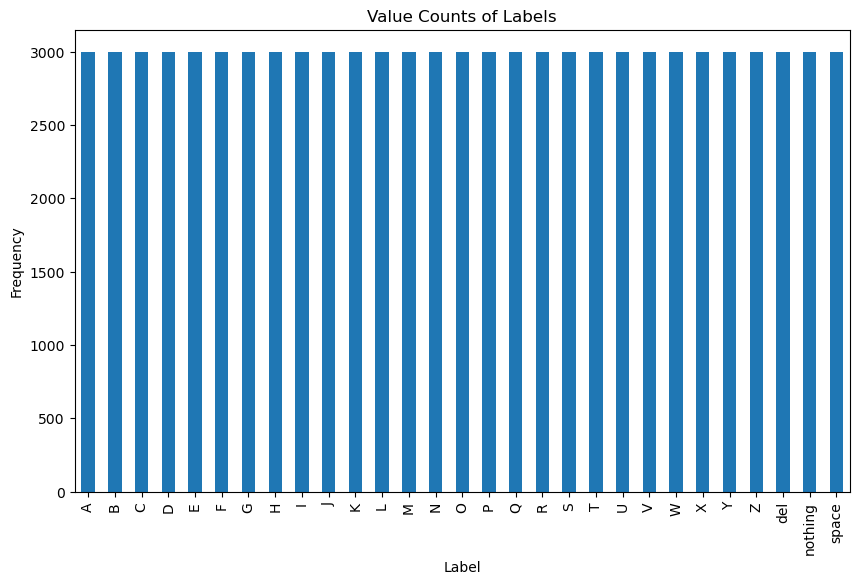

In [3]:
# Check the size and type of data
value_counts = data['label'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
value_counts.plot(kind='bar')
plt.title('Value Counts of Labels')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.xticks()
plt.show()

We have exactly 3000 instances of each letter in the dataset. This is a good thing because it means that the dataset is balanced and large enough to train a model on. Let's take a look at an image looks.

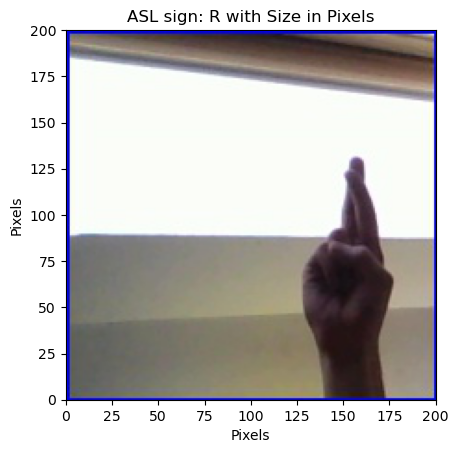

In [4]:
# Check the dimensions of the images.

# Get the path of the first image from the first row
first_instance = data.loc[0]

first_instance_label = first_instance['label']

# Open the first image using PIL
first_img = Image.open(first_instance['imgpath'])

# Get the size of the first image
width, height = first_img.size

plt.imshow(first_img, extent=[0, width, 0, height])
plt.xlabel('Pixels')
plt.ylabel('Pixels')
plt.title(f'ASL sign: {first_instance_label} with Size in Pixels')
plt.show()

The images are 200x200 pixels and are in color. The image is of a hand making a letter in the ASL alphabet. The background is very light and the hand is dark, creating a high contrast. This will make it easier for models to learn the patterns in the images.

### 3. Explore the data

Let's take a closer look at the data and see if we need to do some transformations.

In [5]:
# Create a copy of the data to keep the original data intact
data_copy = data.copy()

We wanna focus on identifying letters, so we will remove the "del", "space" and "nothing" labels from the dataset. These signs are often used in between words or sentences and are not letters in the alphabet.

In [6]:
# Remove blank as we primarily focus on identifying letters of the alphabet
mask = ~data_copy['label'].isin(['blank'])
data_copy = data_copy[mask]
data_copy.reset_index(drop=True, inplace=True)

We have stored the labels in the 'label' column, so we can use that as our target.

In [7]:
# Identify the targets (Supervised learning)
y = data_copy['label']

To get a better overview of how the letters are signed in the images, we will plot an instsance of each letter.

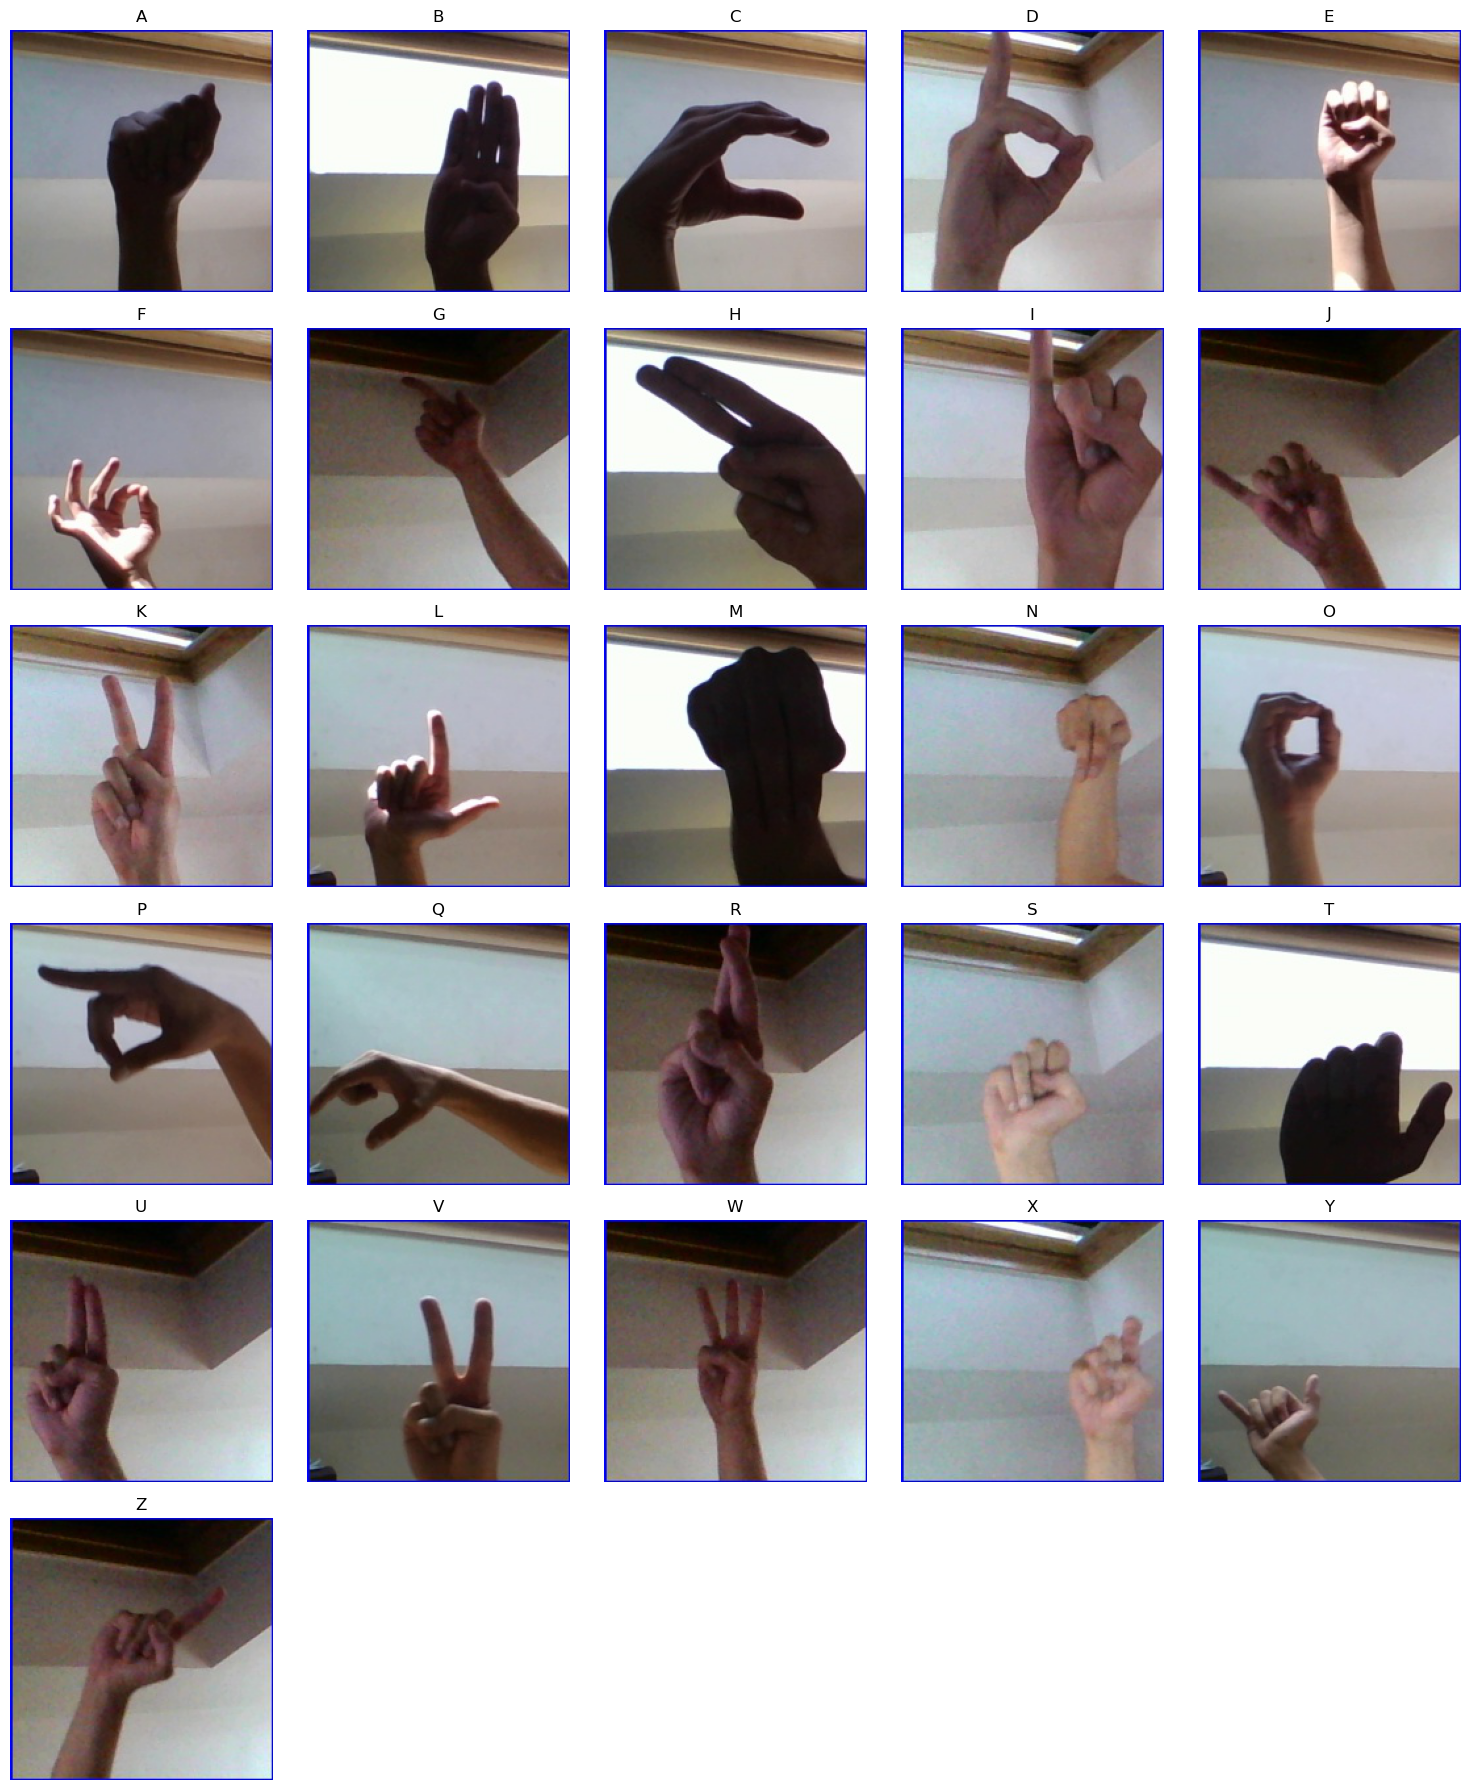

In [8]:
# Visualize the data
unique_labels = data_copy['label'].unique()
num_cols = 5  # Number of columns in the plot grid
num_rows = (len(unique_labels) - 1) // num_cols + 1  # Number of rows based on number of labels
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 3*num_rows))

# Plot one image for each label
for i, label in enumerate(unique_labels):
    # Get any image for the current label
    img_path = data_copy.loc[data_copy['label'] == label, 'imgpath'].iloc[0]
    
    # Open the image using PIL
    img = Image.open(img_path)
    
    # Determine subplot location
    row_index = i // num_cols
    col_index = i % num_cols
    
    # Plot the image
    axes[row_index, col_index].imshow(img)
    axes[row_index, col_index].axis('off')
    axes[row_index, col_index].set_title(label)

# Remove any empty subplots
for i in range(len(unique_labels), num_rows * num_cols):
    row_index = i // num_cols
    col_index = i % num_cols
    fig.delaxes(axes[row_index, col_index])

plt.tight_layout()
plt.show()

The images are very similar in style and contrast, with variance in the positioning of the hand in the image. This is good because, since the models will learn to identify hands in different positions.

Since the images have a size of 200x200 pixels, we will resize them to 64x64 pixels to reduce the amount of data we need to process.

Since the only important part of identifying signs is the shape of the hand, we will also grayscale the image, which will also reduce the amount of data we need to process.

In [9]:
# Identify relevant transformations
output_dir = 'preprocessed_images'

os.makedirs(output_dir, exist_ok=True)

new_size = (64, 64)

def preprocess_image(img_path, output_dir):
     # Read the image in color format
    img = cv2.imread(img_path)        
     # Convert the image to grayscale
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
       
     # Resize the image
    img_resized = cv2.resize(img_gray, new_size)
        
    # Get the filename from the original path
    filename = os.path.basename(img_path)
    
    # Save the preprocessed image to the output directory
    output_path = os.path.join(output_dir, filename)
    cv2.imwrite(output_path, img_resized)
        
    return output_path

data_copy['imgpath'] = data_copy['imgpath'].apply(lambda x: preprocess_image(x, output_dir))

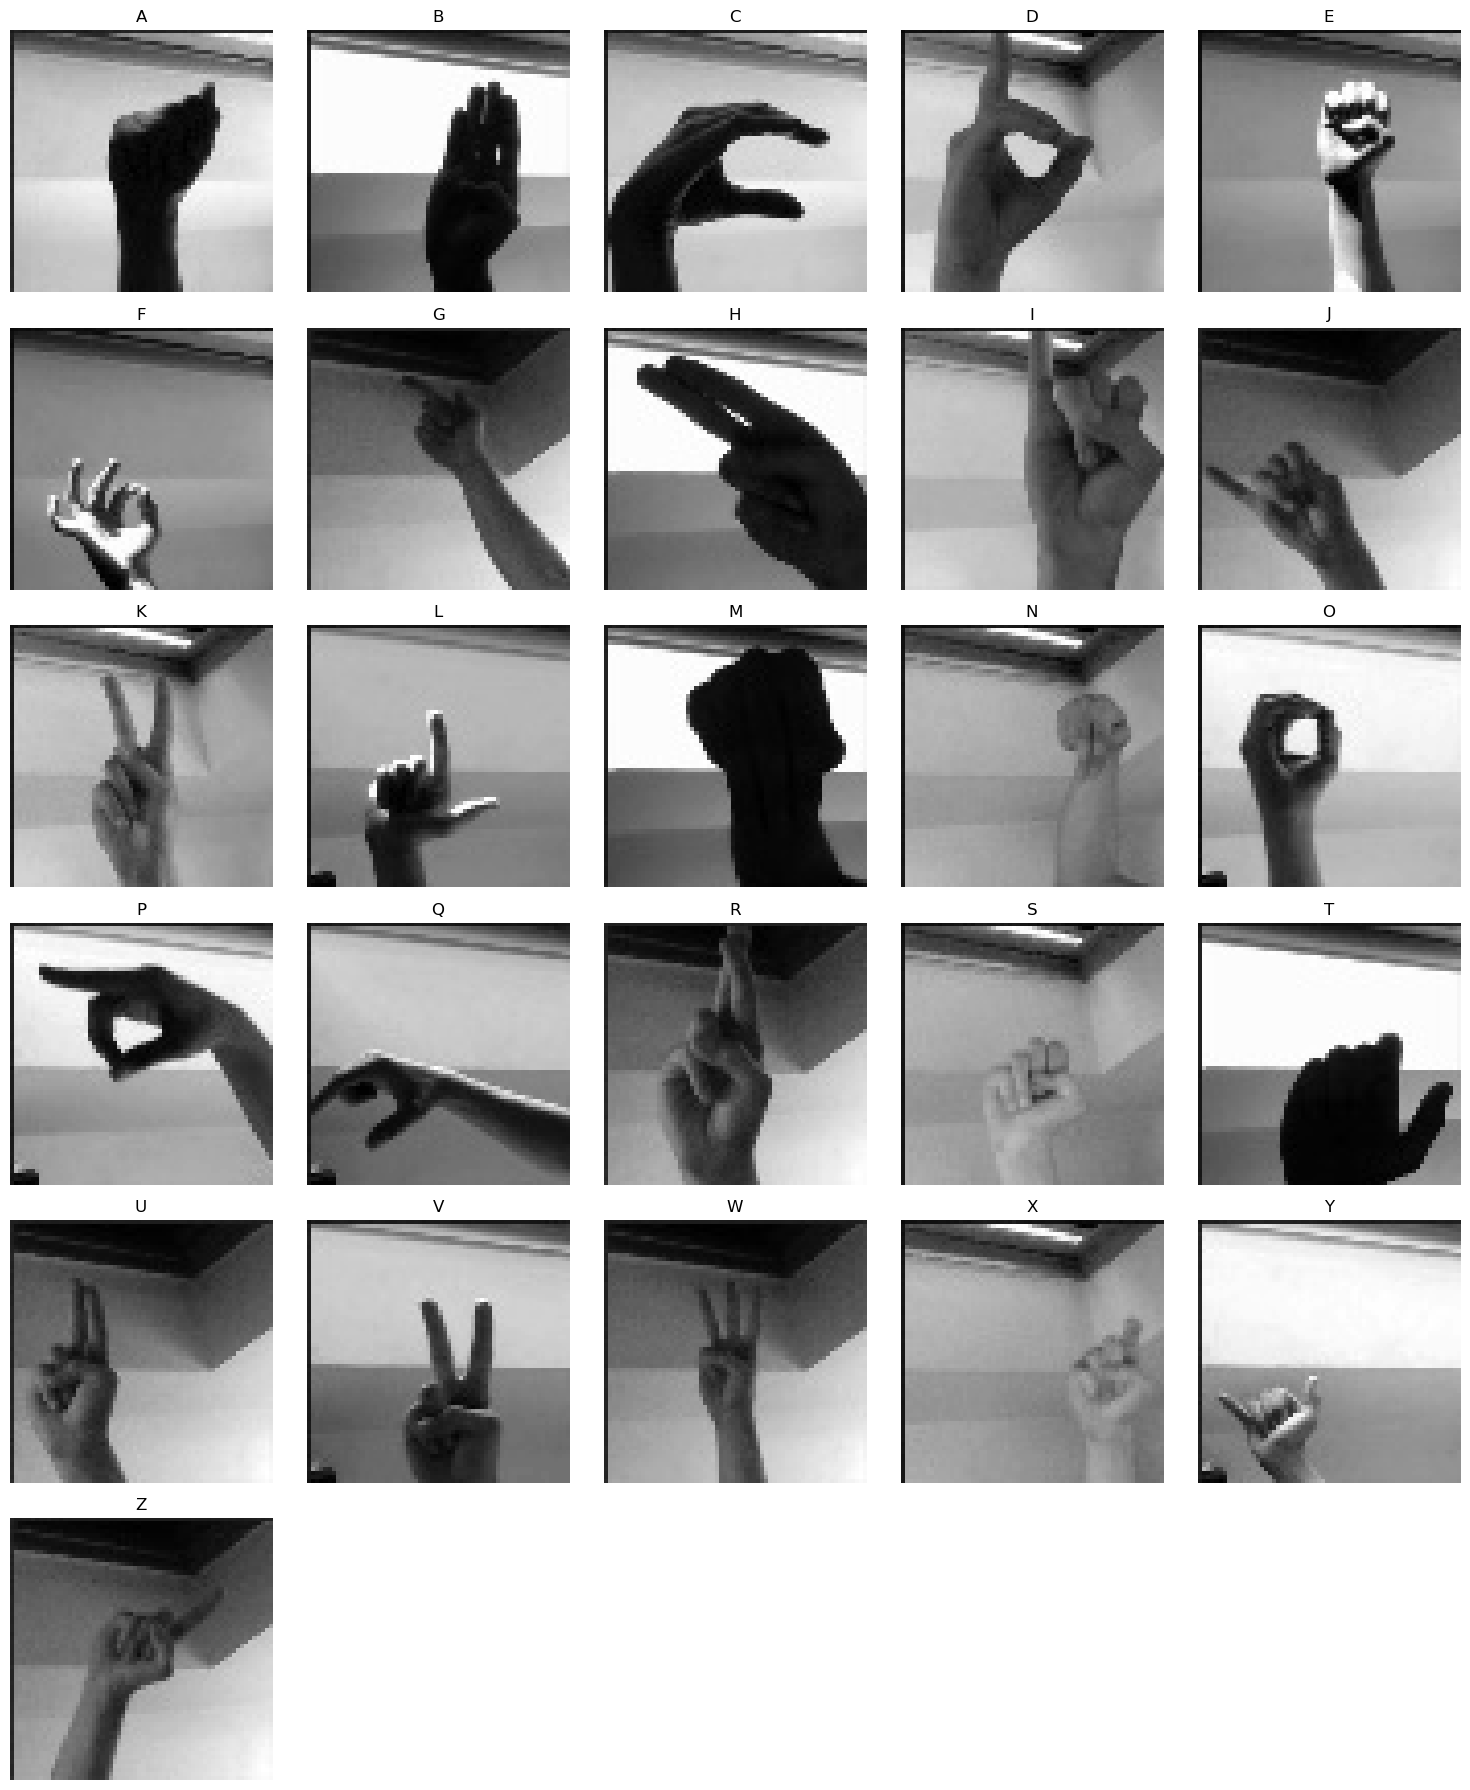

In [10]:
# Visualize the new images
unique_labels = data_copy['label'].unique()
num_cols = 5  # Number of columns in the plot grid
num_rows = (len(unique_labels) - 1) // num_cols + 1  # Number of rows based on number of labels
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 3*num_rows))

# Plot one image for each label
for i, label in enumerate(unique_labels):
    # Get any image for the current label
    img_path = data_copy.loc[data_copy['label'] == label, 'imgpath'].iloc[0]
    
    # Open the image using PIL
    img = Image.open(img_path)
    
    # Determine subplot location
    row_index = i // num_cols
    col_index = i % num_cols
    
    # Plot the image
    axes[row_index, col_index].imshow(img, cmap='gray')
    axes[row_index, col_index].axis('off')
    axes[row_index, col_index].set_title(label)

# Remove any empty subplots
for i in range(len(unique_labels), num_rows * num_cols):
    row_index = i // num_cols
    col_index = i % num_cols
    fig.delaxes(axes[row_index, col_index])

plt.tight_layout()
plt.show()

#### Conclusion on exploring the data

##### Lighting / Colors
By going through the pictures we see that the lighting changes going through the pictures. The images have a hand in different positions within the image, with some different lighting and the same background. 

We've had some talk about the background of the images, as they could be talked about as not entirely "clean" / "monotone". When discussing this in the group, we ended up deciding to use grey-scaling to couteract this possible obstacle. 

Also, we don't want the colors of the background/arm to make a difference when doing the signs, so this is also an argument for grey-scaling the images.

##### Resolution
We will make sure that all of the images will have the same resolution going further into the process. Also, to improve computation time for the model the resolution of the images will be reduced. Which honestly was found by a process of "Do we lose too much information with this resolution?", by still making sure that the model could be trained relativly fast on each of the models, since we know we will use some Gridsearch on the different models. 

The resolution we ended up with is; 64x64, which is in our opinion a nice middle-ground between information in the images and improving the computational time to train the models.

### 4. Prepare the data

In [11]:
# Data cleaning

In [12]:
# Feature selection / engineering / scaling / normalization

Since the models can't process actual images, we will create an array of the pixel values of the images. Since it's grayscaled we will only have one value per pixel.

In [13]:
# Convert image paths to 1D-array of image data and split
def load_image(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    return img.flatten()

X = []
y = []
for _, row in data_copy.iterrows():
    img_path = row['imgpath']
    label = row['label']
    img = load_image(img_path)
    if img is not None:
        X.append(img)
        y.append(label)

X = np.array(X)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 5. Promising models

We train 3 models quick and dirty with default settings to compare performance \
We choose 3 models of varying complexity, to see which model provides the best balance between performance and computational time. We chose KNN, SVM and CNN

#### KNN

KNN is a relatively simple model. It is a good baseline model to compare other models to. It's relatively easy to interpret and understand. It's also relatively fast to train. The downside is that it's not very good at handling large datasets, and will become computationally expensive with a large dataset.

In [14]:
# KNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print(classification_report(y_test, y_pred))

Accuracy: 0.9762820512820513
              precision    recall  f1-score   support

           A       0.96      0.95      0.96       585
           B       0.96      0.97      0.96       580
           C       1.00      0.99      0.99       615
           D       0.98      0.99      0.99       585
           E       0.96      0.95      0.96       609
           F       0.99      0.98      0.99       569
           G       0.99      0.99      0.99       602
           H       0.99      1.00      1.00       562
           I       0.97      0.99      0.98       583
           J       1.00      0.99      0.99       632
           K       0.96      0.97      0.97       623
           L       0.99      0.98      0.99       621
           M       0.98      0.99      0.99       580
           N       1.00      1.00      1.00       643
           O       0.98      0.98      0.98       618
           P       1.00      0.99      1.00       610
           Q       1.00      1.00      1.00       60

We can see from the result that the KNN model has a very high accuracy. 

Vi skal nok bruge et andet test set? Idk, virker sus, så jeg skriver ikke noget om det her endnu

In [15]:
# Create a smaller svm set, since the dataset is too large for SVM
svm_data = data_copy.sample(frac=0.1, random_state=42)
X_svm_train, X_svm_test, y_svm_train, y_svm_test = train_test_split(X, y, test_size=0.2, random_state=42)

# SVM
svm = SVC(kernel='linear')  
svm.fit(X_svm_train, y_svm_train)

# Predict labels for test data
y_pred = svm.predict(X_svm_test)

# Evaluate the model
accuracy = accuracy_score(y_svm_test, y_pred)
print("Accuracy:", accuracy)
print(classification_report(y_svm_test, y_pred))

KeyboardInterrupt: 

In [ ]:
# CNN

### 6. Fine-tune the system

In [ ]:
# Fine-tune hyperparameters

In [ ]:
# Measure performance on test set

### 7. 15-minute video presentation

In [ ]:
# Link here:
